## Test calculations of slope and topographic ruggedness index

Some of the sources used:

http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-slope-works.htm

https://www.usna.edu/Users/oceano/pguth/md_help/html/demb1f3n.htm

http://hydrology.usu.edu/taudem/taudem5/help/D8FlowDirections.html

Burrough, P.A., Mcdonnell, R.A., and Lloyd, C.D. (2015) " Principles of Geographical Information Systems, Third Edition". Oxford University Press, 330 p.

Riley, S. J., DeGloria, S. D., and Elliot, R., 1999, "A terrain ruggedness index that quantifies topographic heterogeneity" Intermountain Journal of Sciences 5:1-4, pp. 23-27.

In [1]:
# raster slope calculation
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import scipy.ndimage
import time
%matplotlib inline

# reproduce the test array in http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-slope-works.htm
ta = np.array([[50.,45.,50.],[30.,30.,30.],[8.,10.,10.]])
print(np.shape(ta))
print(ta)

# reproduce the three test arrays in Riley et al. (1999), Figure 3.
tr1 = np.array([[100.,125.,100.],[125.,200.,125.],[100.,125.,100.]])
tr2 = np.array([[200.,175.,200.],[175.,100.,175.],[200.,175.,200.]])
tr3 = np.array([[200.,210.,220.],[210.,225.,225.],[205.,210.,220.]])
print(tr1)
print(tr2)
print(tr3)

(3, 3)
[[ 50.  45.  50.]
 [ 30.  30.  30.]
 [  8.  10.  10.]]
[[ 100.  125.  100.]
 [ 125.  200.  125.]
 [ 100.  125.  100.]]
[[ 200.  175.  200.]
 [ 175.  100.  175.]
 [ 200.  175.  200.]]
[[ 200.  210.  220.]
 [ 210.  225.  225.]
 [ 205.  210.  220.]]


In [2]:
# test slope equation results for a 3d array
i=1
j=1
dx = 5;
dy = 5;
dzdx=((ta[i-1,j+1]+2.*ta[i,j+1]+ta[i+1,j+1])-(ta[i-1,j-1]+2.*ta[i,j-1]+ta[i+1,j-1]))/(8.*dx)
dzdy=((ta[i+1,j-1]+2.*ta[i+1,j]+ta[i+1,j+1])-(ta[i-1,j-1]+2.*ta[i-1,j]+ta[i-1,j+1]))/(8.*dy)
# slope in fraction (rise over run)
r = (dzdx**2.+dzdy**2.)**(0.5)
# slope in degrees
d = np.degrees(np.arctan(r))
# azimuth in geographic notation
az=np.degrees( np.arctan2(dzdx,dzdy))
az = (az+360.)%360.
print(dzdx, dzdy)
print("This should be 3.80032893313 75.2576576917 179.246151667: \n",r, d, az)

0.05 -3.8
This should be 3.80032893313 75.2576576917 179.246151667: 
 3.80032893313 75.2576576917 179.246151667


In [3]:
### Read in part of a Sandich DEM for testing

xo,yo:  376191.0 4625539.0
xoff, yoff, xend, yend:  2970 4778 3390 5070


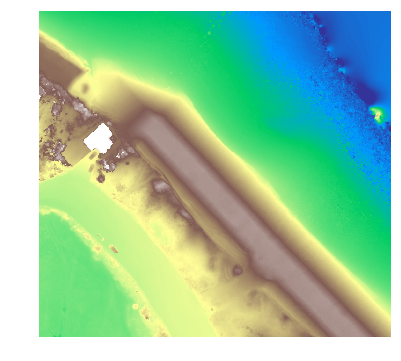

In [4]:
fdir = "F:/2017_Karen_Sandwich_maps/"
fname= "2016-01-22_SandwichTNB_PT_DEM_10cm.tif"

# top left corner of region of interest (UTM Zone 19N meters)
e0 = 376488.; n0 = 4625200.

# size of roi (colums, rows). divide by 10 to get meters
xsize, ysize = 1808, 1680

# declare a plot size
plt.subplots(figsize=(12,6))

with rasterio.open(fdir+fname) as src:
    # location of origin (upper left) from transform
    xo,yo = src.transform*(0,0)
    print('xo,yo: ',xo,yo)
    # index of first col, row in window from inverse transform
    xy = ~src.transform*(e0, n0)
    xoff, yoff = int(xy[0]), int(xy[1])
    print("xoff, yoff, xend, yend: ",xoff, xoff+xsize, yoff, yoff+ysize)
    # Read in a window of the DEM
    # note the x,y switch: syntax for window=((row_start, row_stop)(col_start, col_stop)
    z = src.read(1, window=((yoff,yoff+ysize),(xoff,xoff+xsize)))
    src.close()

# small plots of elevation
plt.axis('off');plt.imshow(z,cmap=plt.cm.terrain,vmin=-2,vmax=8)

In [5]:
def slope(z,dx,dy,idegrees=False):
    """
    Calculate slope using ArcGIS method.
    Horn (1981), cited in Burrough, Macdonald, and Lloyd (2015), equations 10.9 and 10.10
    
    Input:
        z - raster of elevations
        dx, dy - grid spacing (same units as elevation)
        idegrees [optional] - if true, return slope in degrees.
        
    Returns:
        s - slope raster [fraction rise/run] or [degrees, if idegrees=True], same size az z, but will have NaNs around edges
        az - aspect = geographic orientation of slope [degrees]
        
    See Horn (1981), cited in Burrough, Macdonald, and Lloyd (2015), equations 10.9 and 10.10
    """
    ny,nx=np.shape(z)
    s = np.nan * np.ones_like(z)
    az = np.nan * np.ones_like(z)
    for i in range(1,ny-1):
        for j in range(1,nx-1):
            dzdx=((z[i-1,j+1]+2.*z[i,j+1]+z[i+1,j+1])-(z[i-1,j-1]+2.*z[i,j-1]+z[i+1,j-1]))/(8.*dx)
            dzdy=((z[i+1,j-1]+2.*z[i+1,j]+z[i+1,j+1])-(z[i-1,j-1]+2.*z[i-1,j]+z[i-1,j+1]))/(8.*dy)
            # slope in fraction (rise over run); multiply by 100 to get %
            s[i,j] = (dzdx**2.+dzdy**2.)**(0.5)
            # convert to degrees if required.
            if(idegrees):
               s[i,j] = np.degrees(np.arctan(s[i,j]))
            # aspect in geographic notation
            az[i,j] =np.degrees( np.arctan2(dzdx,dzdy))
            az[i,j] = (az[i,j]+360.)%360.
    return s, az

# test on simple test matrix
start_time = time.time()
s, az = slope(ta,5.,5.)
print('Elapsed time: ',time.time()-start_time)
print(s)
print(az)

Elapsed time:  0.0
[[        nan         nan         nan]
 [        nan  3.80032893         nan]
 [        nan         nan         nan]]
[[          nan           nan           nan]
 [          nan  179.24615167           nan]
 [          nan           nan           nan]]


Elapsed time:  51.299946784973145


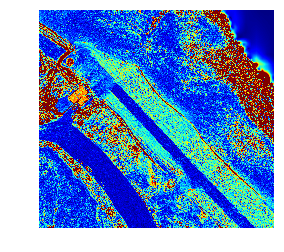

In [6]:
# test on part of Sandwich DEM
start_time = time.time()
s, az = slope(z,.1,.1)
print('Elapsed time: ',time.time()-start_time)
plt.axis('off');plt.imshow(s,cmap=plt.cm.jet,vmin=0.,vmax=.5)

In [29]:
def slope_filter(z,dx,dy,idegrees=False):
    """
    Filter kernal to calculate ArcGIS slope
    Call from scipy.ndimage.filters.generic_filter
        
    Iput:
        z - Raster of elevation values
        dx, dy - Spacing in x and y directions
        idegrees [optional] - when True, converts returned slope to degrees
        
    Returns:
        s - Raster of slopes in fraction (rise/run)
        
    Use the mode option in generic_filter to treat edges
    Suggest mode='nearest'
        
    See Garrard "Geoprocessing with Python", p. 256.
    Horn (1981), cited in Burrough, Macdonald, and Lloyd (2015), equations 10.9 and 10.10
    """
    dzdx=((z[2]+2.*z[5]+z[8])-(z[0]+2.*z[3]+z[6]))/(8.*dx)
    dzdy=((z[6]+2.*z[7]+z[8])-(z[0]+2.*z[1]+z[2]))/(8.*dy)
    # slope in fraction (rise over run)
    s = (dzdx**2.+dzdy**2.)**(0.5)
    if(idegrees):
        s = np.degrees(np.arctan(s))
    return s

def slope_dir_filter(z,dx,dy):
    """
    Filter kernal to calculate ArcGIS slope direction
    Call from scipy.ndimage.filters.generic_filter with size=3
    
    Iput:
        z - Raster of elevation values
        dx, dy - Spacing in x and y directions
        
    Returns:
        az - Raster of slope directions in 0-360
    
    Horn (1981), cited in Burrough, Macdonald, and Lloyd (2015), equations 10.9 and 10.10
    """
    eps = 1e-6
    dzdx=((z[2]+2.*z[5]+z[8])-(z[0]+2.*z[3]+z[6]))/(8.*dx)
    dzdy=((z[6]+2.*z[7]+z[8])-(z[0]+2.*z[1]+z[2]))/(8.*dy)
    # azimuth in geographic notation
    # this will return a number even with zero slopes
    az=np.degrees( np.arctan2(dzdx,dzdy))
    az = (az+360.)%360.
    return az

def tri_filter(z):
    """
    Filter kernal to calculate topographic roughness index
    Call from scipy.ndimage.filters.generic_filter with size=odd_number (typically 3)
    https://gis.stackexchange.com/questions/6056/calculating-topographic-ruggedness-index-in-arcgis-desktop
    Although this cites Rily et al. (1999), it produces numbers that match the post by whuber and does not
    agree with the numbers presented by Riley et al.
    
    Iput:
        z - Raster of elevation values
        
    Returns:
        r - Raster of roughness values
    
    """
    i=len(z)//2
    r = np.sqrt(np.sum((z-z[i])**2))
    return r

def mad_filter(z):
    """
    Filter kernal to mean absolute deviation topographic roughness index
    Call from scipy.ndimage.filters.generic_filter
    
    Iput:
        z - Raster of elevation values
        
    Returns:
        r - Raster of roughness values
    
    """
    i=len(z)//2
    r = np.mean(np.abs(z-z[i]))
    return r

"""
Note that the generic_filter can also call numpy array statistics. Useful ones might be
Range    - np.ptp
Variance - np.var
Std Dev  - np.std
"""

# Tests of slope filter on simple test array
s = scipy.ndimage.filters.generic_filter(ta,slope_filter,size=3,mode='nearest',extra_arguments=(5,5))
az = scipy.ndimage.filters.generic_filter(ta,slope_dir_filter,size=3,mode='nearest',extra_arguments=(5,5))
print(s)
print(az)

DEM = np.array([[1.,2.,3.],[4.,5.,6.],[7.,8.,9.]])
x=DEM.reshape((9,1))

print("Range: ",np.ptp(x),np.ptp(DEM))
print("TRI: ",np.sqrt(np.sum((x-x[4])**2)))
# Tests of topographic roughness index on simple test arrays
r = scipy.ndimage.filters.generic_filter(DEM,tri_filter,size=3,mode='nearest')
print(r)

# Calculate the ArgGIS topographic roughness index per
# https://gis.stackexchange.com/questions/6056/calculating-topographic-ruggedness-index-in-arcgis-desktop
# This produces the same answer as tri_filter, but neither agrees with Riley
#DEM = np.array([[1.,2.,3.],[4.,5.,6.],[7.,8.,9.]])
DEM=tr1

start_time = time.time()
s = scipy.ndimage.filters.generic_filter(DEM,np.sum,size=3,mode='constant')
s2 = np.square(DEM)
t = scipy.ndimage.filters.generic_filter(s2,np.sum,size=3,mode='constant')
r = np.sqrt(t + 9.*s2 - 2.*DEM*s)
print(r)
print('Elapsed time: ',time.time()-start_time)

[[ 1.91213232  1.75        1.91213232]
 [ 4.0256987   3.80032893  3.8770156 ]
 [ 2.15522621  2.05548048  2.        ]]
[[ 191.30993247  180.          168.69006753]
 [ 181.06749968  179.24615167  178.15238973]
 [ 176.0090869   175.81508387  180.        ]]
Range:  8.0 8.0
TRI:  7.74596669241
[[ 6.          5.74456265  4.89897949]
 [ 7.54983444  7.74596669  7.54983444]
 [ 4.89897949  5.74456265  6.        ]]
[[ 247.48737342  231.84046239  247.48737342]
 [ 231.84046239  250.          231.84046239]
 [ 247.48737342  231.84046239  247.48737342]]
Elapsed time:  0.0


Elapsed time:  21.0730721950531


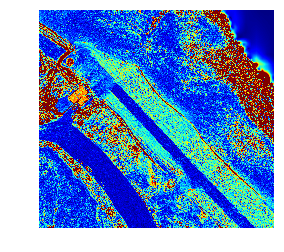

In [8]:
# Tests of slope filters on Sandwich array
start_time = time.time()
s = scipy.ndimage.filters.generic_filter(z,slope_filter,size=3,mode='nearest',extra_arguments=(.1,.1))
az = scipy.ndimage.filters.generic_filter(z,slope_dir_filter,size=3,mode='nearest',extra_arguments=(.1,.1))
print('Elapsed time: ',time.time()-start_time)
plt.axis('off');plt.imshow(s,cmap=plt.cm.jet,vmin=0.,vmax=.5)

In [9]:
# tri filter on Sandwich DEM
start_time = time.time()
tri = scipy.ndimage.filters.generic_filter(z,tri_filter,size=3,mode='nearest')
print('Elapsed time: ',time.time()-start_time)

Elapsed time:  16.003624439239502


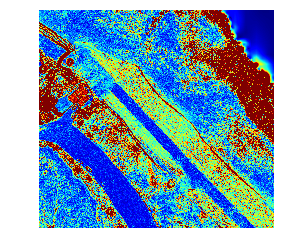

In [18]:
plt.axis('off');plt.imshow(tri,cmap=plt.cm.jet,vmin=0.,vmax=0.1)

In [11]:
# mad filter on Sandwich DEM
start_time = time.time()
mad = scipy.ndimage.filters.generic_filter(z,mad_filter,size=3,mode='nearest')
print('Elapsed time: ',time.time()-start_time)

Elapsed time:  23.02410078048706


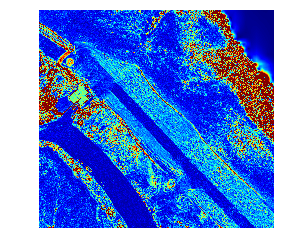

In [19]:
plt.axis('off');plt.imshow(mad,cmap=plt.cm.jet,vmin=0,vmax=0.05)

In [20]:
# range filter on Sandwich DEM
start_time = time.time()
rge = scipy.ndimage.filters.generic_filter(z,np.ptp,size=3,mode='nearest')
print('Elapsed time: ',time.time()-start_time)

Elapsed time:  15.83351182937622


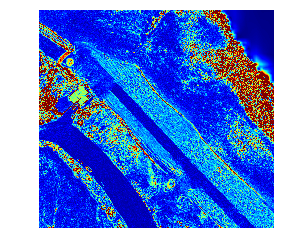

In [31]:
plt.axis('off');plt.imshow(rge,cmap=plt.cm.jet,vmin=0,vmax=0.2)

In [22]:
# std filter on Sandwich DEM
start_time = time.time()
std = scipy.ndimage.filters.generic_filter(z,np.std,size=3,mode='nearest')
print('Elapsed time: ',time.time()-start_time)

Elapsed time:  47.3660614490509


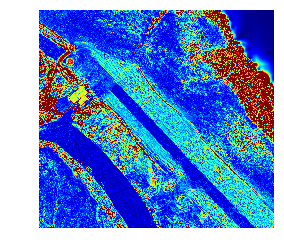

In [30]:
plt.axis('off');plt.imshow(std,cmap=plt.cm.jet,vmin=0.,vmax=0.05)